In [2]:
import sys
import numpy as np
import pandas as pd
from pandas import DataFrame as df
import random
from scipy.optimize import fsolve
from scipy.optimize import minimize
import math
from scipy.stats import norm
from statistics import NormalDist
from scipy.integrate import quad
from itertools import product

In [3]:
# define predetermined values
market_num = 25000
epsilon = 0.0000000001

# define parameters
kappa_1 = 1.2
kappa_2 = 1.2
alpha = 0.5
beta = 1
gamma = 0.5

# define mu of xi's 
mu_xi_1 = 0.03
mu_xi_2 = 0
sigma_xi_1 = 1.5
sigma_xi_2 = 1.5

# define bounds of X and W 
X_upper = 4
X_lower = 1
W_upper = 3
W_lower = 0

In [4]:
def monopoly(x, w, xi, omega):
    mc = np.exp(gamma*w + omega)
    T = np.exp(beta*x - alpha*mc + xi)

    #(1) find Y
    def monopoly_eqn(var):
        Y = var
        eq = 1 - Y + T*np.exp(-Y)
        return eq
    Y = fsolve(monopoly_eqn, 1)[0]
    
    pi = (1/alpha)*(Y-1) 
    price = Y/alpha + mc
    share = pi/(price-mc)

    return pi, price, share

def duopoly(x_1, x_2, w_1, w_2, xi_1, xi_2, omega_1, omega_2):
    mc_1 = np.exp(gamma*w_1 + omega_1) 
    mc_2 = np.exp(gamma*w_2 + omega_2)
    T_1 = np.exp(beta*x_1 - alpha*mc_1 + xi_1)
    T_2 = np.exp(beta*x_2 - alpha*mc_2 + xi_2)
    
    def duopoly_fun(Y):
        Y_1, Y_2 = Y
        eqn1 = Y_1 - math.log(T_1*(Y_2-1)) + math.log(1-Y_2+T_2*np.exp(-Y_2))        
        return abs(eqn1)
    
    def c1(Y):
        'Y_1 exp term greater than 0'
        Y_1, Y_2 = Y
        return 1-Y_1+T_1*np.exp(-Y_1)

    def c2(Y):
        'Y_2 exp term greater than 0'
        Y_1, Y_2 = Y 
        return 1-Y_2+T_2*np.exp(-Y_2)
    
    def c3(Y):
        Y_1, Y_2 = Y
        return Y_2 - math.log(T_2*(Y_1-1)) + math.log(1-Y_1+T_1*np.exp(-Y_1))

    bnds = ((1.000001, None), (1.000001, None))
    cons = ({'type': 'ineq', 'fun': c1}, 
            {'type': 'ineq', 'fun': c2},
            {'type': 'eq', 'fun': c3})
    initial_point = (1.0001, 1.0001)
    res = minimize(duopoly_fun, initial_point, method = 'SLSQP', bounds=bnds, constraints=cons)
    Y_1 = res.x[0]
    Y_2 = res.x[1]
    
    pi_1 = (1/alpha)*(Y_1-1)
    pi_2 = (1/alpha)*(Y_2-1)

    price_1 = Y_1/alpha + mc_1
    price_2 = Y_2/alpha + mc_2

    share_1 = pi_1/(price_1 - mc_1)
    share_2 = pi_2/(price_2 - mc_2)

    return pi_1, pi_2, price_1, price_2, share_1, share_2

In [23]:
def EXP_pi_duo_f1_trapz(x_1, x_2, w_1, w_2, xi_1, xi_2_star, discretize):
    xi_2_vec = np.linspace(xi_2_star, 6 + mu_xi_2, discretize)
    vec_duo = np.vectorize(duopoly)
    trapz_fun1 = vec_duo(x_1, x_2, w_1, w_2, xi_1, xi_2_vec,-0.05, 0.35)[0] * norm.pdf(xi_2_vec, mu_xi_2, sigma_xi_2)
    trapz_fun2 = vec_duo(x_1, x_2, w_1, w_2, xi_1, xi_2_vec,-0.05,-0.05)[0] * norm.pdf(xi_2_vec, mu_xi_2, sigma_xi_2)
    trapz_fun3 = vec_duo(x_1, x_2, w_1, w_2, xi_1, xi_2_vec, 0.35, 0.35)[0] * norm.pdf(xi_2_vec, mu_xi_2, sigma_xi_2)
    trapz_fun4 = vec_duo(x_1, x_2, w_1, w_2, xi_1, xi_2_vec, 0.35,-0.05)[0] * norm.pdf(xi_2_vec, mu_xi_2, sigma_xi_2)
    
    trapz_sum = 0
    for i in range(1,discretize):
        delta_x = xi_2_vec[i] - xi_2_vec[i-1]
        height1 = (1/2)*(trapz_fun1[i] + trapz_fun1[i-1])
        height2 = (1/2)*(trapz_fun2[i] + trapz_fun2[i-1])
        height3 = (1/2)*(trapz_fun3[i] + trapz_fun3[i-1])
        height4 = (1/2)*(trapz_fun4[i] + trapz_fun4[i-1])
        height = (1/4)*(height1+height2+height3+height4)
        trapz_sum += delta_x * height
    prob_f2_in  = 1 - norm.cdf(xi_2_star, loc = mu_xi_2, scale = sigma_xi_2)
    return (1/prob_f2_in)*trapz_sum 

In [24]:
import matplotlib.pyplot as plt

In [25]:
disc_space = np.array([100, 200, 300, 400, 500, 600, 700, 800, 900, 1000])

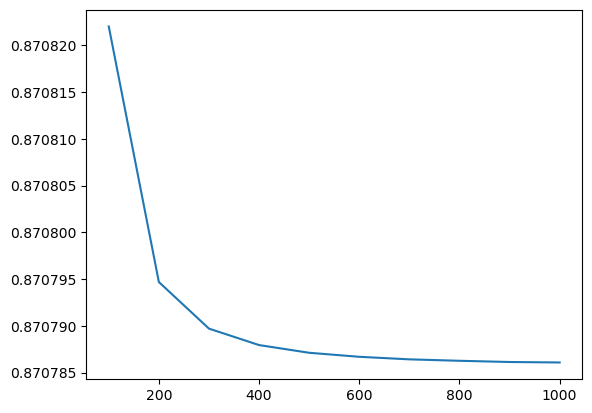

In [26]:
vec_EXP_pi_duo_f1_trapz = np.vectorize(EXP_pi_duo_f1_trapz)

plt.plot(disc_space, vec_EXP_pi_duo_f1_trapz(2,2,1,1,0.5,0,disc_space))

In [27]:
EXP_pi_duo_f1_trapz(2,2,1,1,0.5,0,500)

0.8707871248241726